In [17]:
from myclasses.sql_executor import SQLExecutor
import pandas as pd

if __name__ == "__main__":
    # Create an instance of SQLExecutor
    sql_executor = SQLExecutor()

    # Example SQL query
    query = """
        SELECT 
            state,
            (operating_income / ((total_assets  + total_liabilities) * num_beds)) as roe,
            operating_income,
            year,
            ownership,
            ownership_type,
            snfs_in_city,
            ((total_debt / (total_assets + total_liabilities) * num_beds)) as debt_to_equity_ratio,
            tot_fund_balance,
            current_ratio,
            quick_ratio,
            medicare,
            medicaid,
            pct_fixed_assets,
            pct_other_assets,
            (tot_days / tot_bed_days_avail) as fill_rate,
            cash,
            chow_last_12mos,
            tot_discharge_tot,
            def_score,
            fine_tot,
            fine_cnt,
            resfamcouncil,
            sprinkler_status,
            overall_rating,
            quality_rating,
            staffing_rating,
            rn_staffing_rating,
            aidhrd,
            vochrd,
            rnhrd,
            totlichrd,
            tothrd,
            pthrd,
            weighted_all_cycles_score,
            certification,
            snf_avg_stay_len_title_tot,
            has_outpatient,
            bedcert,
            fac_type,
            staff_style,
            totlichrd_to_tot
            
            
        FROM Master
        WHERE 
            state in('ny', 'fl')
            AND total_assets > 0
            AND total_liabilities > 0 
            
        ORDER BY state; 
        """

    # Execute the query and get the result as a DataFrame
    df = sql_executor.execute_query(query)

In [18]:
# Make y label
y = df['state']
df = df.drop(columns=['state'])

from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler()

# Select numerical columns
quant_cols = df.select_dtypes(include=['number']).columns

# Apply scaling only to the selected numerical columns
df[quant_cols] = scaler.fit_transform(df[quant_cols])

In [19]:
from sklearn.model_selection import train_test_split

# Select columns where data type is text (object)
text_columns = df.select_dtypes(include=['object']).columns

# Create dummy variables for text columns
df_encoded = pd.get_dummies(df, columns=text_columns)

# Convert all columns to numeric type
df_encoded = df_encoded.apply(pd.to_numeric, errors='coerce')

# Set X
X = df_encoded

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

# Convert class labels to integers using LabelEncoder
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Define XGBoost classifier and set hyperparameters for binary classification
xgb_model = xgb.XGBClassifier(
    booster='gbtree',
    seed=1001,
    n_estimators=10000,          # Iterations of the model
    learning_rate=0.0025,         # Speed at which the learners optimize
    max_depth=4,                # Depth of the weak learners
    min_child_weight=1, 
    device='cuda',    
    subsample=0.85,
    colsample_bytree=0.95,
    random_state=42,
    eval_metric='error',         # Binary classification error rate for evaluation
    objective='binary:logistic',  # Use logistic regression for binary classification
    gamma=0.4,                 # Increasing this value will make model more conservative
    reg_alpha=0.49,             # Increasing this value will make model more conservative
    reg_lambda=0.5,             # Increasing this value will make model more conservative
    early_stopping_rounds=2500
)

# Train the model with progress printout
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],  # Evaluation set for tracking progress
    verbose=10                                      # Print progress
)

[0]	validation_0-error:0.46867	validation_1-error:0.44554
[10]	validation_0-error:0.46867	validation_1-error:0.44554
[20]	validation_0-error:0.46867	validation_1-error:0.44554
[30]	validation_0-error:0.16667	validation_1-error:0.16076
[40]	validation_0-error:0.14403	validation_1-error:0.14764
[50]	validation_0-error:0.14140	validation_1-error:0.14698
[60]	validation_0-error:0.13353	validation_1-error:0.14108
[70]	validation_0-error:0.12598	validation_1-error:0.13451
[80]	validation_0-error:0.12369	validation_1-error:0.13123
[90]	validation_0-error:0.12352	validation_1-error:0.13123
[100]	validation_0-error:0.11713	validation_1-error:0.12533
[110]	validation_0-error:0.11253	validation_1-error:0.11811
[120]	validation_0-error:0.11056	validation_1-error:0.11745
[130]	validation_0-error:0.10499	validation_1-error:0.11417
[140]	validation_0-error:0.10515	validation_1-error:0.11745
[150]	validation_0-error:0.10449	validation_1-error:0.11811
[160]	validation_0-error:0.10384	validation_1-error

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.95, device='cuda', early_stopping_rounds=2500,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=0.4, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.0025, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10000, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

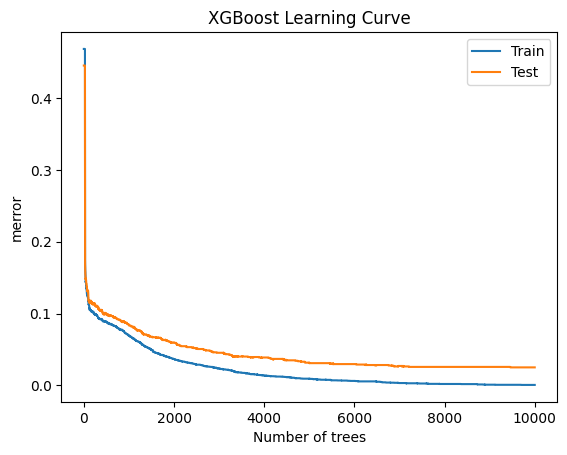

In [21]:
import matplotlib.pyplot as plt

# Get the evaluation results
results = xgb_model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

# Plot the learning curve with multi-logloss
plt.plot(x_axis, results['validation_0']['error'], label='Train')
plt.plot(x_axis, results['validation_1']['error'], label='Test')
plt.legend()
plt.xlabel('Number of trees')
plt.ylabel('merror')
plt.title('XGBoost Learning Curve')
plt.show()

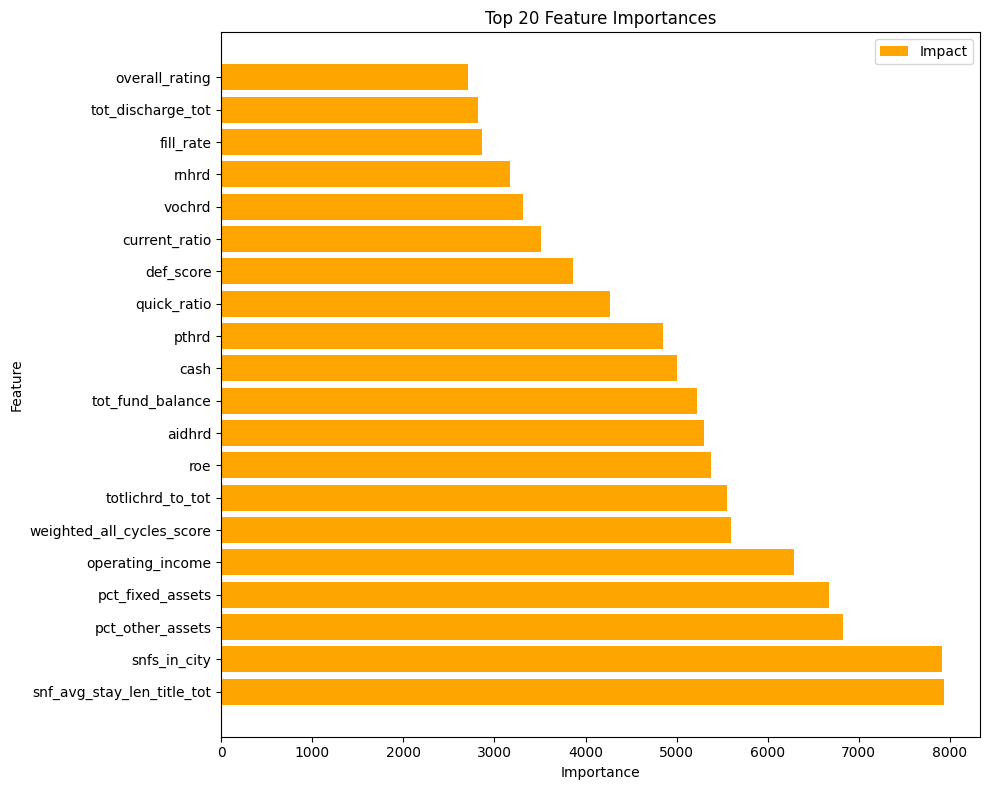

In [22]:
# Get feature importances based on gain
feature_importances  = xgb_model.get_booster().get_score()

# Sort the dictionary by importances in descending order
sorted_feature_importance = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)

# Separate positive and negative importances (since gain is inherently positive)
positive_importances  = dict(sorted_feature_importance)

# Extract feature names and importances
positive_features , positive_importances = zip(*positive_importances.items())

# Select only the top 20 features
top_features  = positive_features [:20]
top_importances  = positive_importances [:20]

# Plot positive importances based on gain for top 20 features
plt.figure(figsize=(10, 8))
plt.barh(top_features , top_importances , color='orange', label='Impact')

plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances')
plt.legend()

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

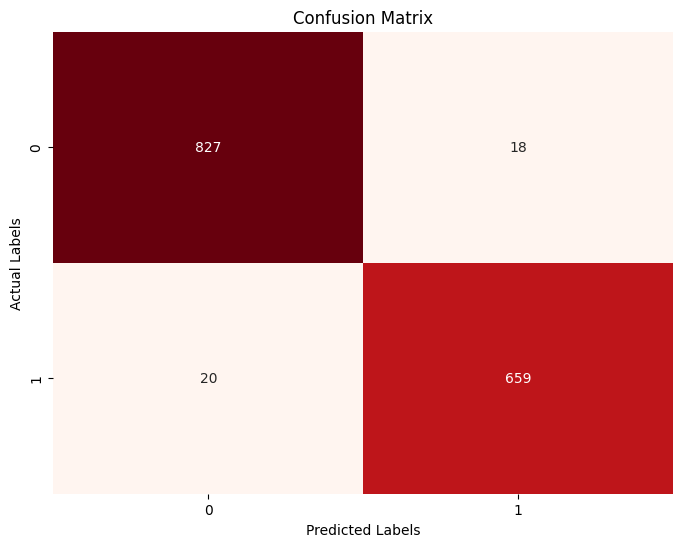

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]  

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')
plt.show()

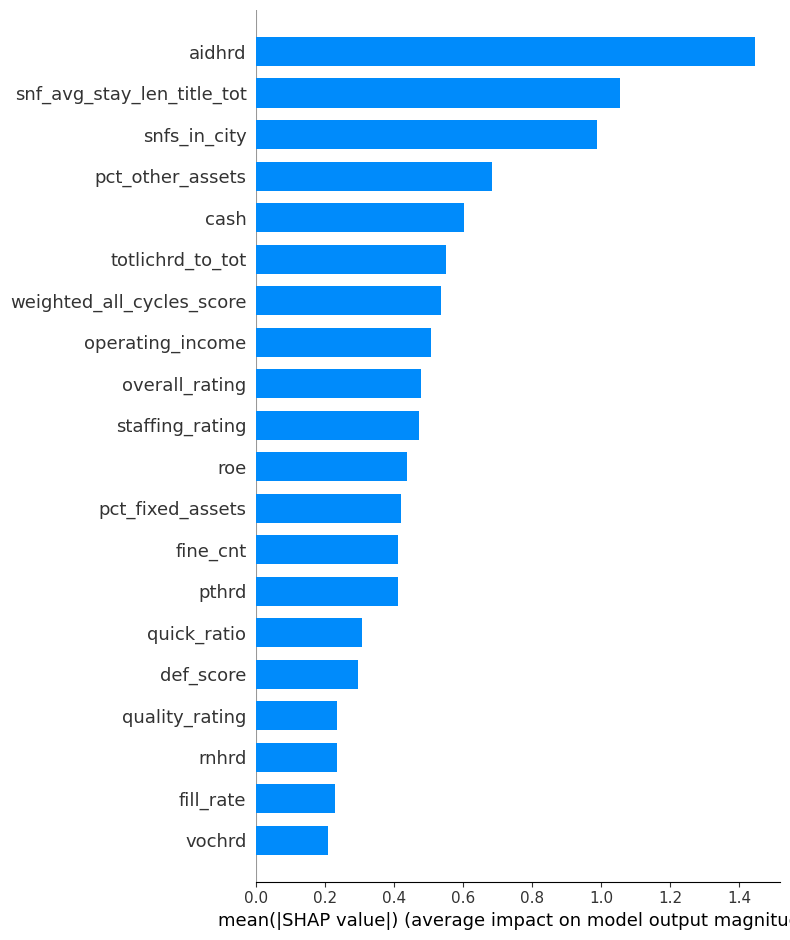

In [24]:
import shap

# Create a SHAP explainer object
explainer = shap.TreeExplainer(xgb_model)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Create a SHAP summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar")